In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [85]:
# # url is really large, I just downloaded the data and loading it in from file since that is easier
# import io
# import requests
# url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv'
# s=requests.get(url).content
# df=pd.read_csv(io.StringIO(s.decode('utf-8')))

I tried to use publically available data but the problem is that we dont have the location. All we get right now is the PLU code, this is very general. Best way to get some data here is to use the taxi data from Kaggle.

In [86]:
df = pd.read_csv('train.csv')

In [87]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Data Information

## File descriptions

* train.csv - the training set (contains 1458644 trip records)
* test.csv - the testing set (contains 625134 trip records)
* sample_submission.csv - a sample submission file in the correct format

## Data fields
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

In [88]:
df.isna().sum() # nothing missing - that's awesome

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [89]:
df['id'].nunique()/len(df) # we can drop id

1.0

In [90]:
df['vendor_id'].unique()

array([2, 1], dtype=int64)

In [91]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(lambda x: 1 if x == "Y" else 0) 

In [92]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,5.515396e-03,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.406066e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,0.000000e+00,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,0.000000e+00,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,0.000000e+00,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.000000e+00,3.526282e+06


In [93]:
df['trip_duration'].mean(),df['trip_duration'].median()

(959.4922729603659, 662.0)

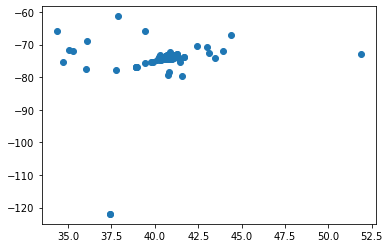

In [94]:
plt.scatter(df['pickup_latitude'], df['pickup_longitude'])

In [95]:
df = df.query('trip_duration < 2*3600')
df = df.query('pickup_latitude < 45 and pickup_longitude > - 90')

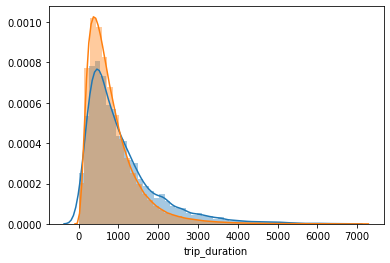

In [97]:
# sns.distplot(df_small.trip_duration) # lookie the trip duration - looks like a log normal
sns.distplot(df.query('store_and_fwd_flag == 1')['trip_duration'])
sns.distplot(df.query('store_and_fwd_flag == 0')['trip_duration'])


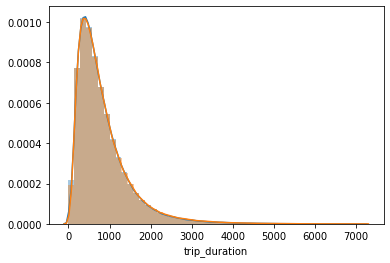

In [105]:
# sns.distplot(df_small.trip_duration) # lookie the trip duration - looks like a log normal
sns.distplot(df.query('vendor_id == 1')['trip_duration'])
sns.distplot(df.query('vendor_id == 2')['trip_duration'])
# drop vendor id - does not matter

In [106]:
df['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

## Drop all long time?

SHould I drop all > 10k? Some data are definitely bad, especially if I am just sitting for  a long time running the meter without any customer.

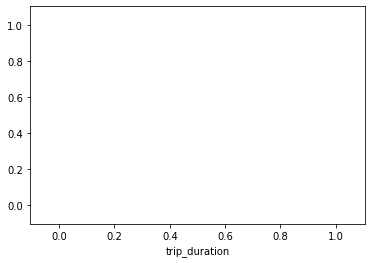

In [107]:
sns.distplot(df.query('trip_duration > 10000 and trip_duration < 80000')['trip_duration'])

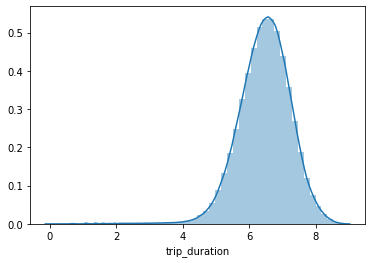

In [108]:
sns.distplot(np.log(df.trip_duration))

In [109]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'rough_distance', 'speed'],
      dtype='object')

In [110]:
df['rough_distance'] = (111321*((df['pickup_latitude']-df['dropoff_latitude'])**2+ (df['pickup_longitude']-df['dropoff_longitude'])**2 ))
df['speed'] = df.rough_distance/df.trip_duration

In [111]:
df.speed.mean(),df.speed.quantile(0.25),df.speed.quantile(.5),df.speed.quantile(0.75)

(0.25517939465473427,
 0.040876841505818745,
 0.08184393443687979,
 0.18223031038053847)

Can come up wiht some concoction related to the distance but much faster and easier right now to drop

## Smaller

Use df_small since it  has trashed all values > 2 hours

In [112]:
dfs = df.copy()

In [113]:
dfs.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'rough_distance', 'speed'],
      dtype='object')

In [114]:
dfs['pu_day']= dfs['pickup_datetime'].dt.day
dfs['pu_hour']= dfs['pickup_datetime'].dt.hour
dfs['pu_month']= dfs['pickup_datetime'].dt.month
dfs['pu_year']= dfs['pickup_datetime'].dt.year
dfs['pu_minute']= dfs['pickup_datetime'].dt.minute
dfs['pu_weekday']=dfs['pickup_datetime'].dt.weekday

In [115]:
dfs.drop(['id','vendor_id','pickup_datetime','dropoff_datetime'],axis=1,inplace=True)

In [116]:
dfs.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,rough_distance,speed,pu_day,pu_hour,pu_month,pu_year,pu_minute,pu_weekday
0,1,-73.982155,40.767937,-73.964630,40.765602,0,455,34.795173,0.076473,14,17,3,2016,24,0
1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,46.581605,0.070259,12,0,6,2016,43,6
2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,399.871746,0.188264,19,11,1,2016,35,1
3,1,-74.010040,40.719971,-74.012268,40.706718,0,429,20.102944,0.046860,6,19,4,2016,32,2
4,1,-73.973053,40.793209,-73.972923,40.782520,0,435,12.720303,0.029242,26,13,3,2016,30,5


# Baseline

In [117]:
X,y = dfs.drop('trip_duration',axis=1), dfs['trip_duration']

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score

In [119]:
def get_train_test(X,y):
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

def get_new_baseline(X_train, X_val, y_train, y_val,plot=True):
    rf = RandomForestRegressor()
    model = rf.fit(X_train,y_train)
    preds=rf.predict(X_val)
    if plot == True:
        return mean_absolute_error(y_val,preds),y_val,preds
    else:
        return mean_absolute_error(y_val,preds)

In [30]:
X_train, X_val, y_train, y_val = get_train_test(dfs.drop('trip_duration',axis=1), dfs['trip_duration'])
res,true,pred = get_new_baseline(X_train, X_val, y_train, y_val)
print(res)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


193.77421132316437


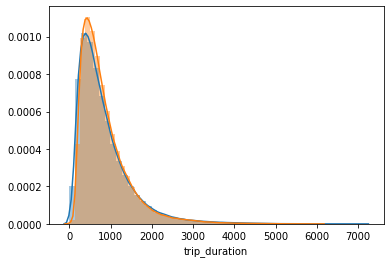

In [31]:
sns.distplot(true)
sns.distplot(pred)

# Feature Engineering

### Distance
Added horizontal, vertical and mannhattan distance

In [161]:
dfs['horiz_dist'] = dfs['pickup_latitude']-dfs['dropoff_latitude']
dfs['vertical_dist'] = dfs['pickup_longitude']-dfs['dropoff_longitude']
dfs['mann_dist'] = np.abs(dfs['pickup_longitude']-dfs['dropoff_longitude'])+np.abs(dfs['pickup_latitude']-dfs['dropoff_latitude'])

In [165]:
X_train, X_val, y_train, y_val = get_train_test(dfs.drop('trip_duration',axis=1), dfs['trip_duration'])
res,true,pred = get_new_baseline(X_train, X_val, y_train, y_val)
print(res)

In [178]:
# from sklearn.inspection import permutation_importance
# result = permutation_importance(model, X_val, y_cal, n_repeats=10,random_state=42)
# perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(model.feature_importances_)
# tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# ax1.barh(tree_indices,
#          clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
# ax1.set_yticklabels(data.feature_names)
# ax1.set_yticks(tree_indices)
# ax1.set_ylim((0, len(clf.feature_importances_)))
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
#             labels=data.feature_names)
# fig.tight_layout()
# plt.show()

### Coords

* Interaction between coordinates - like lat and long
* neighborhood?

In [169]:
# direction of travel
dfs['direction'] = np.tan(dfs['vertical_dist']/ (dfs['horiz_dist']+0.0000001))

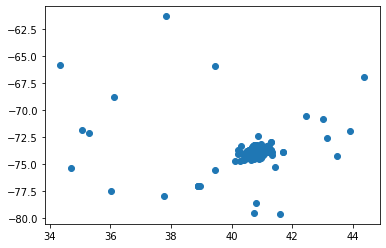

In [122]:
plt.scatter(df['pickup_latitude'],df['pickup_longitude'])

In [145]:
dfs = dfs.query('pickup_latitude > 40 and pickup_latitude < 42 and pickup_longitude < -73 and pickup_longitude > -75').query('dropoff_latitude > 40 and dropoff_latitude < 42 and dropoff_longitude < -73 and dropoff_longitude > -75')

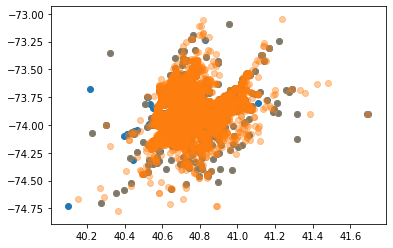

In [146]:
plt.scatter(tmp['pickup_latitude'],tmp['pickup_longitude'])
plt.scatter(tmp['dropoff_latitude'],tmp['dropoff_longitude'],alpha=0.4)

In [148]:
from sklearn.cluster import AgglomerativeClustering, KMeans
clus = KMeans(n_clusters=5)
clus.fit(tmp[['pickup_latitude','pickup_longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

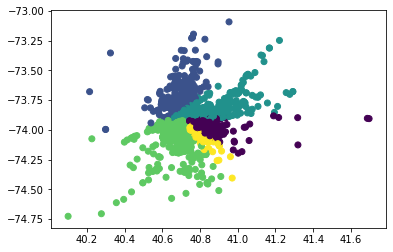

In [153]:
cluster_lab = clus.predict(tmp[['pickup_latitude','pickup_longitude']])
plt.scatter(tmp['pickup_latitude'],tmp['pickup_longitude'],c=cluster_lab)
# plt.scatter(tmp['dropoff_latitude'],tmp['dropoff_longitude'],alpha=0.4)

In [176]:
dfs['pickup_nbd'] = clus.predict(dfs[['pickup_latitude','pickup_longitude']])
dfs['dropoff_nbd'] = clus.predict(dfs[['dropoff_latitude','dropoff_longitude']])

In [177]:
# try again added neighborhood and direction and removed more outliers
X_train, X_val, y_train, y_val = get_train_test(dfs.drop('trip_duration',axis=1), dfs['trip_duration'])
res,true,pred = get_new_baseline(X_train, X_val, y_train, y_val)
print(res)

3.3073714115037864


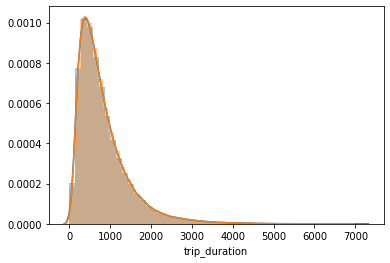

In [179]:
sns.distplot(true)
sns.distplot(pred)

In [182]:
dfs.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'rough_distance', 'speed', 'pu_day', 'pu_hour',
       'pu_month', 'pu_year', 'pu_minute', 'pu_weekday', 'horiz_dist',
       'vertical_dist', 'mann_dist', 'direction', 'pickup_nbd', 'dropoff_nbd'],
      dtype='object')